In [1]:
import time
from datetime import datetime
from datasets import DatasetDict, Dataset
from functools import lru_cache
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import warnings
from gluonts.time_feature import get_lags_for_frequency
from gluonts.time_feature import time_features_from_frequency_str
from gluonts.time_feature import (
    time_features_from_frequency_str,
    TimeFeature,
    get_lags_for_frequency,
)
from gluonts.dataset.field_names import FieldName
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    AddTimeFeatures,
    AsNumpyArray,
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    RemoveFields,
    SelectFields,
    SetField,
    TestSplitSampler,
    Transformation,
    ValidationSplitSampler,
    VstackFeatures,
    RenameFields,
)
import wandb

warnings.filterwarnings('ignore')

In [2]:
nations = Path('nations').glob('*.csv')

dataset = {
    'train': [],
    'validation': [],
    'test': [],
}

for key, nation in enumerate(nations):
    df = pd.read_csv(nation, index_col='Date')
    fx = df['FX'].tolist()

    start = datetime.strptime('2004-07-26', '%Y-%m-%d')
    feat_dynamic_real = StandardScaler().fit_transform(df.drop(columns='FX').values)

    dataset['train'].append({
        'start': start,
        'target': fx[:-60],
        'feat_static_cat': [key],
        'feat_dynamic_real': feat_dynamic_real[:-60].T.tolist(),
        'item_id': nation.stem,
    })

    dataset['validation'].append({
        'start': start,
        'target': fx[:-30],
        'feat_static_cat': [key],
        'feat_dynamic_real': feat_dynamic_real[:-30].T.tolist(),
        'item_id': nation.stem,
    })

    dataset['test'].append({
        'start': start,
        'target': fx,
        'feat_static_cat': [key],
        'feat_dynamic_real': feat_dynamic_real.T.tolist(),
        'item_id': nation.stem,
    })

train_dataset = Dataset.from_list(dataset['train'])
validation_dataset = Dataset.from_list(dataset['validation'])
test_dataset = Dataset.from_list(dataset['test'])

dataset = DatasetDict({
    'train': train_dataset,
    'validation': validation_dataset,
    'test': test_dataset
})

In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 17
    })
    validation: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 17
    })
    test: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 17
    })
})

In [4]:
train_example = dataset['train'][0]
train_example.keys()

dict_keys(['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'])

In [5]:
print(train_example['start'])
print(len(train_example['target']))

2004-07-26 00:00:00
5080


In [6]:
validation_example = dataset['validation'][0]
validation_example.keys()

dict_keys(['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'])

In [7]:
print(validation_example['start'])
print(len(validation_example['target']))

2004-07-26 00:00:00
5110


In [8]:
freq = "1D"
prediction_length = 30
assert len(train_example["target"]) + prediction_length == len(validation_example["target"])

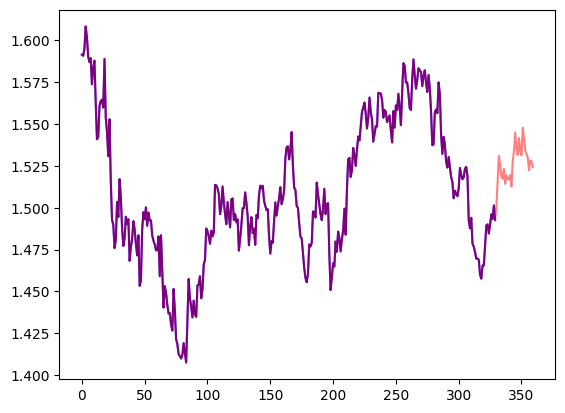

In [9]:
figure, axes = plt.subplots()
axes.plot(train_example["target"][-11 * 30:], color="blue")
axes.plot(validation_example["target"][-12 * 30:], color="red", alpha=0.5)

plt.show()

In [10]:
train_dataset = dataset["train"]
test_dataset = dataset["test"]

In [11]:
@lru_cache(10_000)
def convert_to_pandas_period(date, freq):
    return pd.Period(date, freq)

def transform_start_field(batch, freq):
    batch["start"] = [convert_to_pandas_period(date, freq) for date in batch["start"]]
    return batch

In [12]:
from functools import partial

train_dataset.set_transform(partial(transform_start_field, freq=freq))
validation_dataset.set_transform(partial(transform_start_field, freq=freq))
test_dataset.set_transform(partial(transform_start_field, freq=freq))

In [13]:
# lags_sequence = get_lags_for_frequency(freq)
lags_sequence = [1, 2, 3, 4, 5, 6, 7, 11, 12, 13, 23, 24, 25, 35, 36, 37]

In [14]:
time_features = time_features_from_frequency_str(freq)
time_features

[<function gluonts.time_feature._base.day_of_week(index: pandas.core.indexes.period.PeriodIndex) -> numpy.ndarray>,
 <function gluonts.time_feature._base.day_of_month(index: pandas.core.indexes.period.PeriodIndex) -> numpy.ndarray>,
 <function gluonts.time_feature._base.day_of_year(index: pandas.core.indexes.period.PeriodIndex) -> numpy.ndarray>]

In [15]:
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerForPrediction

config = TimeSeriesTransformerConfig(
    prediction_length=prediction_length,
    
    # context length:
    context_length=prediction_length * 3,
    
    # lags coming from helper given the freq:
    lags_sequence=lags_sequence,
    
    # we'll add 2 time features ("month of year" and "age", see further):
    num_time_features=len(time_features) + 1,
    
    # we have a single static categorical feature, namely time series ID:
    num_static_categorical_features=1,
    
    # it has 366 possible values:
    cardinality=[len(train_dataset)],
    
    # the model will learn an embedding of size 1 for each of the 366 possible values:
    embedding_dimension=[1],
    
    # transformer params:
    encoder_layers=4,
    decoder_layers=4,
    d_model=32,
)

model = TimeSeriesTransformerForPrediction(config)

In [16]:
model.config.distribution_output

'student_t'

In [17]:
from transformers import PretrainedConfig

def create_transformation(freq: str, config: PretrainedConfig) -> Transformation:
    remove_field_names = []
    if config.num_static_real_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_REAL)
    if config.num_dynamic_real_features == 0:
        remove_field_names.append(FieldName.FEAT_DYNAMIC_REAL)
    if config.num_static_categorical_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_CAT)

    # a bit like torchvision.transforms.Compose
    return Chain(
        # step 1: remove static/dynamic fields if not specified
        [RemoveFields(field_names=remove_field_names)]
        # step 2: convert the data to NumPy (potentially not needed)
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_CAT,
                    expected_ndim=1,
                    dtype=int,
                )
            ]
            if config.num_static_categorical_features > 0
            else []
        )
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_REAL,
                    expected_ndim=1,
                )
            ]
            if config.num_static_real_features > 0
            else []
        )
        + [
            AsNumpyArray(
                field=FieldName.TARGET,
                # we expect an extra dim for the multivariate case:
                expected_ndim=1 if config.input_size == 1 else 2,
            ),
            # step 3: handle the NaN's by filling in the target with zero
            # and return the mask (which is in the observed values)
            # true for observed values, false for nan's
            # the decoder uses this mask (no loss is incurred for unobserved values)
            # see loss_weights inside the xxxForPrediction model
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
            ),
            # step 4: add temporal features based on freq of the dataset
            # month of year in the case when freq="M"
            # these serve as positional encodings
            AddTimeFeatures(
                start_field=FieldName.START,
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_TIME,
                time_features=time_features_from_frequency_str(freq),
                pred_length=config.prediction_length,
            ),
            # step 5: add another temporal feature (just a single number)
            # tells the model where in its life the value of the time series is,
            # sort of a running counter
            AddAgeFeature(
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_AGE,
                pred_length=config.prediction_length,
                log_scale=True,
            ),
            # step 6: vertically stack all the temporal features into the key FEAT_TIME
            VstackFeatures(
                output_field=FieldName.FEAT_TIME,
                input_fields=[FieldName.FEAT_TIME, FieldName.FEAT_AGE]
                + (
                    [FieldName.FEAT_DYNAMIC_REAL]
                    if config.num_dynamic_real_features > 0
                    else []
                ),
            ),
            # step 7: rename to match HuggingFace names
            RenameFields(
                mapping={
                    FieldName.FEAT_STATIC_CAT: "static_categorical_features",
                    FieldName.FEAT_STATIC_REAL: "static_real_features",
                    FieldName.FEAT_TIME: "time_features",
                    FieldName.TARGET: "values",
                    FieldName.OBSERVED_VALUES: "observed_mask",
                }
            ),
        ]
    )

In [18]:
from gluonts.transform.sampler import InstanceSampler
from typing import Optional

def create_instance_splitter(
    config: PretrainedConfig,
    mode: str,
    train_sampler: Optional[InstanceSampler] = None,
    validation_sampler: Optional[InstanceSampler] = None,
) -> Transformation:
    assert mode in ["train", "validation", "test"]

    instance_sampler = {
        "train": train_sampler
        or ExpectedNumInstanceSampler(
            num_instances=1.0, min_future=config.prediction_length
        ),
        "validation": validation_sampler
        or ValidationSplitSampler(min_future=config.prediction_length),
        "test": TestSplitSampler(),
    }[mode]

    return InstanceSplitter(
        target_field="values",
        is_pad_field=FieldName.IS_PAD,
        start_field=FieldName.START,
        forecast_start_field=FieldName.FORECAST_START,
        instance_sampler=instance_sampler,
        past_length=config.context_length + max(config.lags_sequence),
        future_length=config.prediction_length,
        time_series_fields=["time_features", "observed_mask"],
    )

In [19]:
from typing import Iterable

import torch
from gluonts.itertools import Cached, Cyclic
from gluonts.dataset.loader import as_stacked_batches


def create_train_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    num_batches_per_epoch: int,
    shuffle_buffer_length: Optional[int] = None,
    cache_data: bool = True,
    **kwargs,
) -> Iterable:
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    TRAINING_INPUT_NAMES = PREDICTION_INPUT_NAMES + [
        "future_values",
        "future_observed_mask",
    ]

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=True)
    if cache_data:
        transformed_data = Cached(transformed_data)

    # we initialize a Training instance
    instance_splitter = create_instance_splitter(config, "train")

    # the instance splitter will sample a window of
    # context length + lags + prediction length (from the 366 possible transformed time series)
    # randomly from within the target time series and return an iterator.
    stream = Cyclic(transformed_data).stream()
    training_instances = instance_splitter.apply(
        stream, is_train=True
    )
    
    return as_stacked_batches(
        training_instances,
        batch_size=batch_size,
        shuffle_buffer_length=shuffle_buffer_length,
        field_names=TRAINING_INPUT_NAMES,
        output_type=torch.tensor,
        num_batches_per_epoch=num_batches_per_epoch,
    )


In [20]:
def create_test_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    **kwargs,
):
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=False)

    # we create a Test Instance splitter which will sample the very last
    # context window seen during training only for the encoder.
    instance_sampler = create_instance_splitter(config, "test")

    # we apply the transformations in test mode
    testing_instances = instance_sampler.apply(transformed_data, is_train=False)
    
    return as_stacked_batches(
        testing_instances,
        batch_size=batch_size,
        output_type=torch.tensor,
        field_names=PREDICTION_INPUT_NAMES,
    )


In [21]:
training_config = {
    "learning_rate": 6e-4,
    "architecture": "time-series-transformer",
    "dataset": "fx-nations",
    "epochs": 60,
    "batch_size": 256,
    "wandb": True,
    "num_batches_per_epoch": 100,
}

In [22]:
train_dataloader = create_train_dataloader(
    config=config,
    freq=freq,
    data=train_dataset,
    batch_size=training_config["batch_size"],
    num_batches_per_epoch=training_config["num_batches_per_epoch"],
)

validation_dataloader = create_train_dataloader(
    config=config,
    freq=freq,
    data=validation_dataset,
    batch_size=training_config["batch_size"],
    num_batches_per_epoch=training_config["num_batches_per_epoch"],
)

test_dataloader = create_test_dataloader(
    config=config,
    freq=freq,
    data=test_dataset,
    batch_size=training_config["batch_size"],
)

In [23]:
batch = next(iter(train_dataloader))
for k, v in batch.items():
    print(k, v.shape, v.type())

past_time_features torch.Size([256, 127, 4]) torch.FloatTensor
past_values torch.Size([256, 127]) torch.FloatTensor
past_observed_mask torch.Size([256, 127]) torch.FloatTensor
future_time_features torch.Size([256, 30, 4]) torch.FloatTensor
static_categorical_features torch.Size([256, 1]) torch.IntTensor
future_values torch.Size([256, 30]) torch.FloatTensor
future_observed_mask torch.Size([256, 30]) torch.FloatTensor


In [24]:
# perform forward pass
outputs = model(
    past_values=batch["past_values"],
    past_time_features=batch["past_time_features"],
    past_observed_mask=batch["past_observed_mask"],
    static_categorical_features=batch["static_categorical_features"]
    if config.num_static_categorical_features > 0
    else None,
    static_real_features=batch["static_real_features"]
    if config.num_static_real_features > 0
    else None,
    future_values=batch["future_values"],
    future_time_features=batch["future_time_features"],
    future_observed_mask=batch["future_observed_mask"],
    output_hidden_states=True,
)

In [25]:
print("Loss:", outputs.loss.item())

Loss: 4.274876117706299


In [26]:
if training_config["wandb"]:
    # start a new wandb run to track this script
    wandb.init(
        # set the wandb project where this run will be logged
        project="time-series-transformers",
    
        # track hyperparameters and run metadata
        config=training_config
    )

wandb: Currently logged in as: xunhaoz. Use `wandb login --relogin` to force relogin


In [ ]:
from accelerate import Accelerator
from torch.optim import AdamW

accelerator = Accelerator()
device = accelerator.device

model.to(device)
optimizer = AdamW(model.parameters(), lr=training_config["learning_rate"], betas=(0.9, 0.95), weight_decay=1e-1)

model, optimizer, train_dataloader = accelerator.prepare(
    model,
    optimizer,
    train_dataloader,
)


for epoch in range(training_config["epochs"]):
    start_time = time.time()
    train_loss = 0.0
    validation_loss = 0.0
    
    model.train()
    for idx, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = model(
            static_categorical_features=batch["static_categorical_features"].to(device)
            if config.num_static_categorical_features > 0
            else None,
            static_real_features=batch["static_real_features"].to(device)
            if config.num_static_real_features > 0
            else None,
            past_time_features=batch["past_time_features"].to(device),
            past_values=batch["past_values"].to(device),
            future_time_features=batch["future_time_features"].to(device),
            future_values=batch["future_values"].to(device),
            past_observed_mask=batch["past_observed_mask"].to(device),
            future_observed_mask=batch["future_observed_mask"].to(device),
        )
        loss = outputs.loss

        # Backpropagation
        accelerator.backward(loss)
        optimizer.step()

        if idx % 100 == 0:
            train_loss += loss.item()
        
    model.eval()
    for idx, batch in enumerate(validation_dataloader):
        outputs = model(
            static_categorical_features=batch["static_categorical_features"].to(device)
            if config.num_static_categorical_features > 0
            else None,
            static_real_features=batch["static_real_features"].to(device)
            if config.num_static_real_features > 0
            else None,
            past_time_features=batch["past_time_features"].to(device),
            past_values=batch["past_values"].to(device),
            future_time_features=batch["future_time_features"].to(device),
            future_values=batch["future_values"].to(device),
            past_observed_mask=batch["past_observed_mask"].to(device),
            future_observed_mask=batch["future_observed_mask"].to(device),
        )
        loss = outputs.loss

        if idx % 100 == 0:
            validation_loss += loss.item()
    
    end_time = time.time()
    
    print(f"Epoch {epoch} | Train Loss: {train_loss:.2f} | Validation Loss: {validation_loss:.2f} | Time: {end_time - start_time:.2f}")
    if training_config["wandb"]:
        wandb.log({
            "train_loss": train_loss,
            "validation_loss": validation_loss,
        })

Epoch 0 | Train Loss: 3.76 | Validation Loss: 2.29 | Time: 13.31
Epoch 1 | Train Loss: 2.63 | Validation Loss: 1.91 | Time: 10.60
Epoch 2 | Train Loss: 1.99 | Validation Loss: 2.00 | Time: 10.48
Epoch 3 | Train Loss: 1.56 | Validation Loss: 1.19 | Time: 10.53
Epoch 4 | Train Loss: 1.37 | Validation Loss: 1.07 | Time: 10.50
Epoch 5 | Train Loss: 1.02 | Validation Loss: 1.06 | Time: 10.43
Epoch 6 | Train Loss: 0.95 | Validation Loss: 1.07 | Time: 11.23
Epoch 7 | Train Loss: 0.92 | Validation Loss: 0.69 | Time: 11.02
Epoch 8 | Train Loss: 0.49 | Validation Loss: 0.46 | Time: 11.04
Epoch 9 | Train Loss: 0.95 | Validation Loss: 0.78 | Time: 11.25
Epoch 10 | Train Loss: 0.76 | Validation Loss: 0.54 | Time: 11.07
Epoch 11 | Train Loss: 0.81 | Validation Loss: 0.72 | Time: 11.30
Epoch 12 | Train Loss: 0.86 | Validation Loss: 0.49 | Time: 11.32
Epoch 13 | Train Loss: 0.80 | Validation Loss: 0.35 | Time: 11.36
Epoch 14 | Train Loss: 0.16 | Validation Loss: 0.33 | Time: 11.14
Epoch 15 | Train Los

In [ ]:
if training_config["wandb"]:
    wandb.finish()

In [ ]:
model.eval()

forecasts = []

for batch in test_dataloader:
    outputs = model.generate(
        static_categorical_features=batch["static_categorical_features"].to(device)
        if config.num_static_categorical_features > 0
        else None,
        static_real_features=batch["static_real_features"].to(device)
        if config.num_static_real_features > 0
        else None,
        past_time_features=batch["past_time_features"].to(device),
        past_values=batch["past_values"].to(device),
        future_time_features=batch["future_time_features"].to(device),
        past_observed_mask=batch["past_observed_mask"].to(device),
    )
    forecasts.append(outputs.sequences.cpu().numpy())


In [ ]:
forecasts[0].shape

In [ ]:
forecasts = np.vstack(forecasts)
print(forecasts.shape)

In [ ]:
from evaluate import load
from gluonts.time_feature import get_seasonality

mase_metric = load("evaluate-metric/mase")
smape_metric = load("evaluate-metric/smape")

forecast_median = np.median(forecasts, 1)

mase_metrics = []
smape_metrics = []
for item_id, ts in enumerate(test_dataset):
    training_data = ts["target"][:-prediction_length]
    ground_truth = ts["target"][-prediction_length:]
    mase = mase_metric.compute(
        predictions=forecast_median[item_id], 
        references=np.array(ground_truth), 
        training=np.array(training_data), 
        periodicity=get_seasonality(freq))
    mase_metrics.append(mase["mase"])
    
    smape = smape_metric.compute(
        predictions=forecast_median[item_id], 
        references=np.array(ground_truth), 
    )
    smape_metrics.append(smape["smape"])


In [ ]:
print(f"MASE: {np.mean(mase_metrics)}")
print(f"sMAPE: {np.mean(smape_metrics)}")

In [ ]:
plt.scatter(mase_metrics, smape_metrics, alpha=0.3)
plt.xlabel("MASE")
plt.ylabel("sMAPE")
plt.show()

In [ ]:
import matplotlib.dates as mdates

def plot(ts_index):
    fig, ax = plt.subplots()

    index = pd.period_range(
        start=test_dataset[ts_index][FieldName.START],
        periods=len(test_dataset[ts_index][FieldName.TARGET]),
        freq=freq,
    ).to_timestamp()

    # Major ticks every half year, minor ticks every month,
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
    ax.xaxis.set_minor_locator(mdates.MonthLocator())

    ax.plot(
        index[-2*prediction_length:], 
        test_dataset[ts_index]["target"][-2*prediction_length:],
        label="actual",
    )

    plt.plot(
        index[-prediction_length:], 
        np.median(forecasts[ts_index], axis=0),
        label="median",
    )
    
    plt.fill_between(
        index[-prediction_length:],
        forecasts[ts_index].mean(0) - forecasts[ts_index].std(axis=0), 
        forecasts[ts_index].mean(0) + forecasts[ts_index].std(axis=0), 
        alpha=0.3, 
        interpolate=True,
        label="+/- 1-std",
    )
    plt.legend()
    plt.show()


In [ ]:
for i in range(17):
    plot(i)